# **Apogee Data Pipeline**

Current Issues 
- BIC scores - correct trend not current scale 
- Assignment incorrect 
- Maybe try without scaling - add as an optional/ only scale energy
- maybe scalling of covaraiance matrix is going wrong


In [1]:
from analysis import XDPipeline
from analysis import apogee_filter

"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 07-05-2025 from 10:00 to 12:00 (CEST)"


In [2]:
# Set true to rerun XD analysis - approx 10 hours for 100 iterations with 3 repeats per gaussian component
rerun_XD = False

## **Importing/ Filtering Apogee Data**

| **Dataset**         | **Variable**                     | **Description** |
|---------------------|---------------------------------|----------------|
| **Apogee Data**      | `apogee_data_path`              | Contains stellar data from Apogee DR3, including elemental abundances, and additional data |


###  apogee_filter
- Preforms a series of data quality cuts outlined by docstring below
- Also preforms SQL queries to retain Gaia data, including photogeometric distance estimates from *Bailer-Jones 2021* (VAC).


In [3]:
apogee_data_path = 'data/raw/Apogee_GM/Apogee_DS_GM.csv'

apogee_data_filtered_path = 'data/filtered/Apogee/Apogee_data_filtered_1612.csv'

In [4]:
?apogee_filter

Signature: apogee_filter(star_data_in, SQL=False, save_path=None)
Docstring:
Applies quality cuts to APOGEE stellar data to produce a refined 
sample of chemically selected stars with extreme kinematics.

This function filters stars based on data quality, chemical abundances, 
and orbital properties to isolate **metal-poor stars with extreme orbits**.

If `SQL=True`, Gaia DR3 distances are queried using the **astroquery** package, 
and an additional filtering step removes stars with large distance errors.

Parameters
----------
star_data_in : str, Table, np.recarray, or pd.DataFrame
    APOGEE stellar data, provided as a file path (CSV, FITS, TXT) or an 
    Astropy Table, NumPy recarray, or Pandas DataFrame.

SQL : bool, optional
    If `True`, queries Gaia DR3 for distances using `astroquery.gaia` 
    and applies additional filtering based on distance uncertainties.
    Defaults to `False`.

save_path : str, optional
    If provided, saves the filtered dataset as a FITS file at the 

In [5]:
apogee_processed_data = apogee_filter(apogee_data_path, SQL=True, save_path = apogee_data_filtered_path)

INFO:root:Initial number of stars: 1706
INFO:root:Querying Gaia for distances...
Processing Queries: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
INFO:root:Final number of stars: 1612
INFO:root:Fraction retained: 94.49%
INFO:root:Filtered dataset saved to data/filtered/Apogee/Apogee_data_filtered_1612.csv


## **XD Pipeline**
- The XD pipeline contains the following processes and functionalities

In [6]:
?XDPipeline

Init signature:
XDPipeline(
    star_data: Union[astropy.table.table.Table, numpy.rec.recarray, pandas.core.frame.DataFrame],
    data_keys: List[str],
    data_err_keys: List[str],
)
Docstring:     
A pipeline for performing Extreme Deconvolution (XD) using a Gaussian Mixture Model (GMM).

Aims at analysing and fitting multi-dimensional stellar datasets.

The pipeline follows these key steps:

1. **Initialisation** (`__init__`):
   - Takes in stellar data as an Astropy Table, NumPy recarray, or Pandas DataFrame.
   - Extracts relevant features defined by `data_keys` and their errors `data_err_keys`.

2. **Extreme Deconvolution (XD)** (`run_XD`):
   - Normalises the dataset for efficient convergence.
   - Runs XD over a specified range of Gaussian components.
   - Iterates through multiple random initialisations to ensure robust fitting.
   - Uses BIC and AIC scores to evaluate model performance.
   - Optionally saves results to a file for later analysis.

3. **Model Comparison & Selec

### **Initialisation of Pipeline**
- Imports revelent total data set and the keys for the data features (and corrosponding errors of intrest)

In [7]:
apogee_data_keys = ['fe_h', 'alpha_m', 'E_50', 'ce_fe', 'al_fe', 'mg_mn']
apogee_data_error_keys = ['fe_h_err', 'alpha_m_err', 'E_err', 'ce_fe_err', 'al_fe_err', 'mg_mn_err']

apogee_pipeline = XDPipeline(apogee_processed_data, apogee_data_keys, apogee_data_error_keys)

### **XD Run Overview**  

#### **Parameters**  

| **Parameter**                     | **Value**  |
|------------------------------------|------------|
| **Max EM Iterations**              | \(10^9\)   |
| **Number of Gaussian Components**  | 0 – 10     |
| **Repeats per Gaussian Component** | 3          |
| **Initializations per Repeat**     | 100        |

#### **Stored Data**  
- Achieved Weights, Means, and Covariances for each run  
- Model Evaluation Metrics:  
  - AIC (Akaike Information Criterion)
  - BIC (Bayesian Information Criterion)

In [8]:
?XDPipeline.run_XD

Signature:
XDPipeline.run_XD(
    self,
    gauss_component_range: Tuple[int, int] = (1, 10),
    max_iterations: int = 1000000000,
    n_repeats: int = 3,
    n_init: int = 100,
    save_path: Optional[str] = None,
) -> None
Docstring:
Run Extreme Deconvolution (XD) for a range of Gaussian components with multiple random initializations.
The results are evaluated using BIC and AIC for model selection.

Parameters
----------
gauss_component_range : Tuple[int, int]
    Range of Gaussian components to test, specified as (min, max).
max_iterations : int
    Maximum number of EM iterations per XD run.
n_repeats : int
    Number of complete repetitions of the initialization process.
n_init : int
    Number of random initializations per component count.
save_path : Optional[str]
    Path to save XD results. If None, results are not saved.

Raises
------
ValueError
    If `gauss_component_range` is invalid.
TypeError
    If `n_repeats`, `n_init`, or `max_iterations` are not positive integers.

In [9]:
if rerun_XD:
    apogee_pipeline.run_XD(gauss_component_range=(1,10), max_iterations=int(1e9), n_repeats=3, n_init=100, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl')

### **Run Results Analysis** 

#### **Overall**

| **Overall Results Analysis**                        | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | None |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |

#### **Filtered**

| **Filtered Results Analysis**   | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | 5 Gaussian Components |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |


In [10]:
?XDPipeline.compare_XD

Signature:
XDPipeline.compare_XD(
    self,
    opt_metric='BIC',
    n_gauss_filter: Optional[int] = None,
    repeat_no_filter: Optional[int] = None,
    save_path: Optional[str] = None,
) -> None
Docstring:
Analyse Extreme Deconvolution (XD) results using BIC or AIC.
This method identifies the best-fit model, summarizes failed runs, and visualizes score distributions.
If no filters are applied, the analysis is performed on all results. Otherwise, it is performed on filtered results.

Parameters
----------
opt_metric : str
    Optimization metric ('BIC' or 'AIC').
n_gauss_filter : Optional[int]
    Specific number of Gaussian components to filter results by.
repeat_no_filter : Optional[int]
    Specific repeat cycle to filter results by.
save_path : Optional[str]
    Path to load XD results if not already stored in the class.

Raises
------
ValueError
    If results are not available in the class and no valid `save_path` is given.
ValueError
    If `opt_metric` is not 'BIC' or 'AIC'.

 Best Overall BIC Score: 20257.9314 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 2
   - Initialisation (i): 7
 The following filters were applied: {'n_gauss': 7, 'repeat': None}
 Best BIC Score from filtered inputs: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73
Table of Number of Gaussians vs Number of Failed XD Runs
+----+-----------------+----------------------+------------------+
|    |   No. Gaussians |   No. Failed XD runs |   Total No. Runs |
|----+-----------------+----------------------+------------------|
|  0 |               1 |                    0 |              300 |
|  1 |               2 |                    0 |              300 |
|  2 |               3 |                    0 |              300 |
|  3 |               4 |                    0 |              300 |
|  4 |               5 |                    0 |              300 |
|  5 |               6 |                    0 |

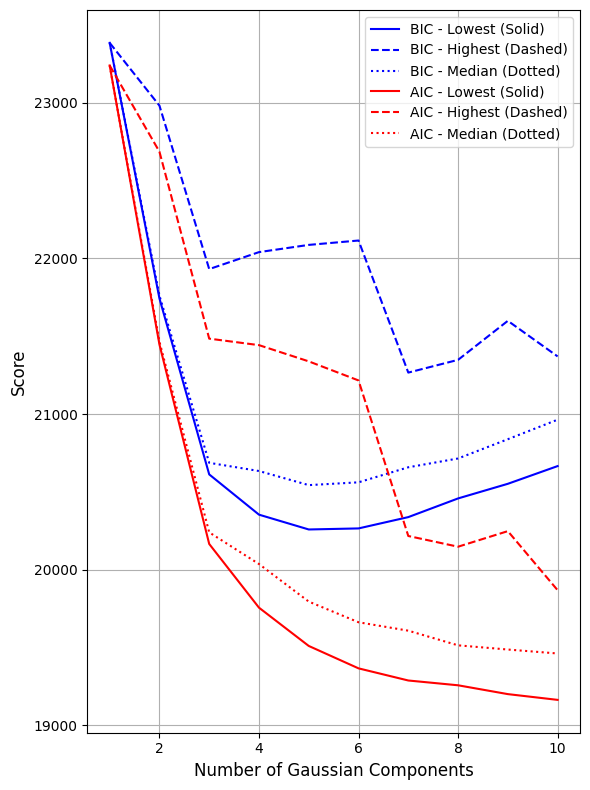

In [11]:
apogee_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 7, repeat_no_filter = None, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl')

### **Determine Responsibilities and Assignment**

- Use the gaussian components from the best XD run of filter subset (best filtered)

In [12]:
?XDPipeline.assigment_XD

Signature: XDPipeline.assigment_XD(self, assignment_metric='best')
Docstring:
Assign stars to Gaussian components based on the best-fit XD model.
Computes the responsibility of each gaussians for each star and assigns it accordingly.

This method performs assignment in scaled feature space using StandardScaler to reproduce
the scaling used during XD fitting. Covariance matrices are adjusted to include measurement
errors, and ill-conditioned matrices are regularized to ensure numerical stability.

Parameters
----------
assignment_metric : str
    Selection criteria for the best-fit model ('best' or 'best filtered').

Raises
------
ValueError
    If no XD results are available.
ValueError
    If an invalid `assignment_metric` is specified.

Returns
-------
None
    Updates `star_data` in place to include probability assignments:
        - `prob_gauss_{i}`: Probability of belonging to the i-th Gaussian component.
        - `max_gauss`: Index of the component with the highest probability (

In [13]:
apogee_pipeline.assigment_XD(assignment_metric = 'best filtered')

Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73


### **Print Summary of Gaussian Components and Assigment**


In [14]:
?XDPipeline.table_results_XD

Signature:
XDPipeline.table_results_XD(
    self,
    component_name_dict: dict = None,
    combine: list = None,
    labels_combined: list = None,
) -> pandas.core.frame.DataFrame
Docstring:
Generate a summary table of the Extreme Deconvolution (XD) results showing the mean and error values of each Gaussian in high-dimensional space.

For each Gaussian the table includes:
- Component Name (indexed numerically or custom if a mapping is provided)
- XD assigned Weight (%)
- Count of assigned stars
- Count as a percentage of the total assigned stars
- Mean values and standard deviations for each feature parameter

Parameters
----------
component_name_dict : dict, optional
    A dictionary mapping component indices (0-based) to custom names.
    The table will be ordered according to the order of keys in this dictionary if provided.
combine : list of list of int, optional
    List of lists, where each inner list contains indices of components to be combined.
labels_combined : list of str, 

In [15]:
labels = {
    0: "GS/E 1",
    5: "GS/E 2",
    2: "Splash",
    6: "Aurora",
    1: "Eos",
    4: "Back 1",
    3: "Back 2"
}

apogee_gauss_summary = apogee_pipeline.table_results_XD(labels, combine=[[0, 5], [3, 4]], labels_combined = ['GS/E', 'Background'])


Summary of GMM Fit Result for GALAH-Gaia Sample
+----+-------------+--------------+---------+-------------+--------------+-------------+-----------------------+--------------+--------------+-------------+
|    | Component   |   Weight (%) |   Count |   Count (%) | fe_h         | alpha_m     | E_50                  | ce_fe        | al_fe        | mg_mn       |
+====+=============+==============+=========+=============+==============+=============+=======================+==============+==============+=============+
|  0 | GS/E 1      |         19.6 |     299 |        18.5 | -0.94 ± 0.16 | 0.15 ± 0.05 | -155064.59 ± 11192.51 | -0.15 ± 0.01 | -0.22 ± 0.03 | 0.39 ± 0.08 |
+----+-------------+--------------+---------+-------------+--------------+-------------+-----------------------+--------------+--------------+-------------+
|  1 | GS/E 2      |         31.9 |     541 |        33.6 | -1.29 ± 0.16 | 0.22 ± 0.02 | -149500.44 ± 15743.03 | -0.20 ± 0.05 | -0.24 ± 0.04 | 0.54 ± 0.11 |
+----+---

### **Plot Results**  
- Generates a 2D plot of **Extreme Deconvolution (XD)** results.  
- Stars are colored by their assigned Gaussian component.  
- Gaussian components are shown as confidence ellipses.  
- Includes marginal histograms and a bar chart of component weights.  
- Confidence interval adjustable via `z_score` (default: 2 ~ 95%). 

In [16]:
?XDPipeline.plot_XD

Signature:
XDPipeline.plot_XD(
    self,
    x_key: str,
    y_key: str,
    z_score: float = 2.0,
    full_survey_file: Optional[str] = None,
    color_palette: Optional[list] = None,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
) -> None
Docstring:
Creates a 2D plot of the Extreme Deconvolution (XD) results, displaying:
- Individual stars colored by their assigned Gaussian component
- Gaussian mixture model (GMM) components as confidence ellipses
- Marginal histograms and KDE distributions for each axis
- A bar chart representing the relative weight of each Gaussian component
- Optional 2D histogram of full survey sample as grayscale background

The confidence ellipses are scaled according to a given z-score, providing 
a visual representation of the spread of each Gaussian component.

Parameters
----------
x_key : str
    The column name corresponding to the x-axis variable.
y_key : str
    The column name corresponding to the y-axis variable.
z_score : float,

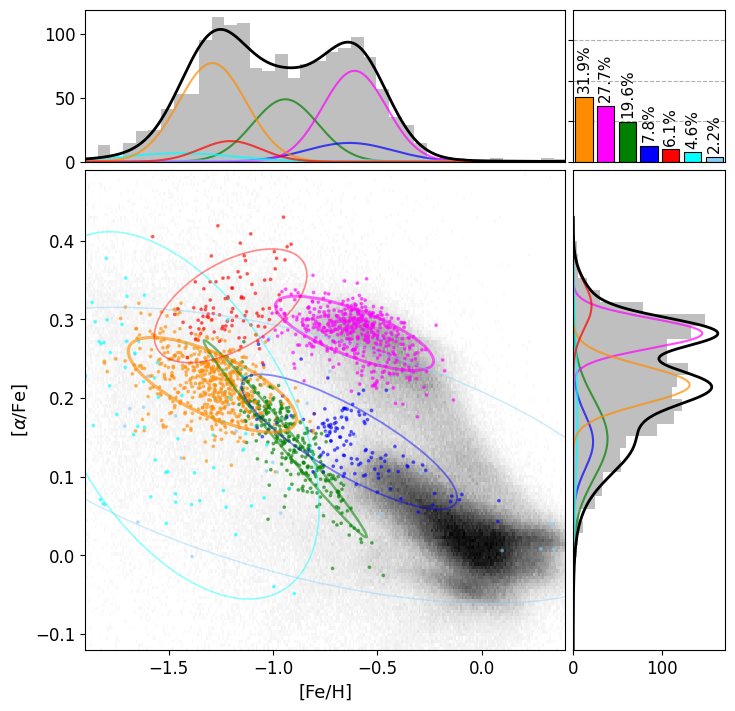

In [17]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='alpha_m',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.12, 0.49),
)

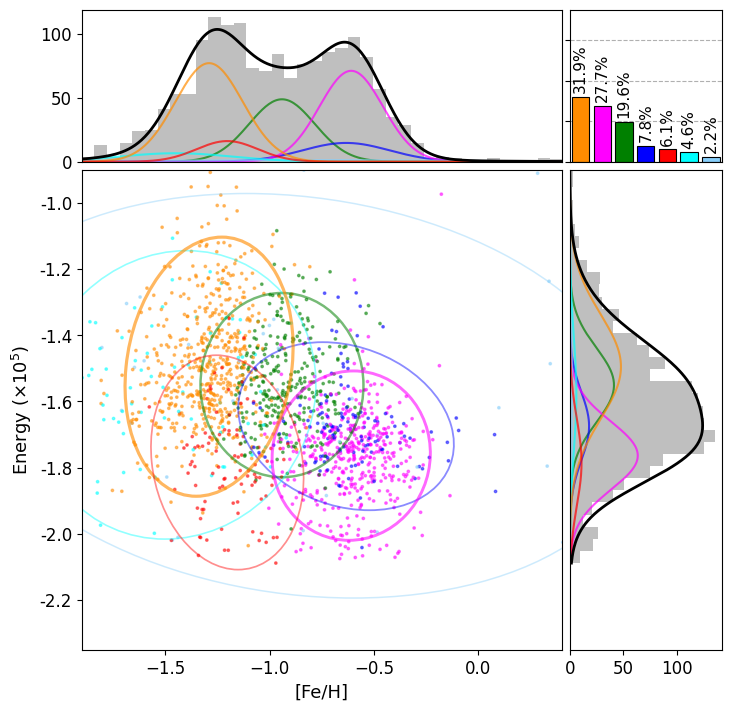

In [18]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='E_50',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-2.35e5, -0.9e5),
)

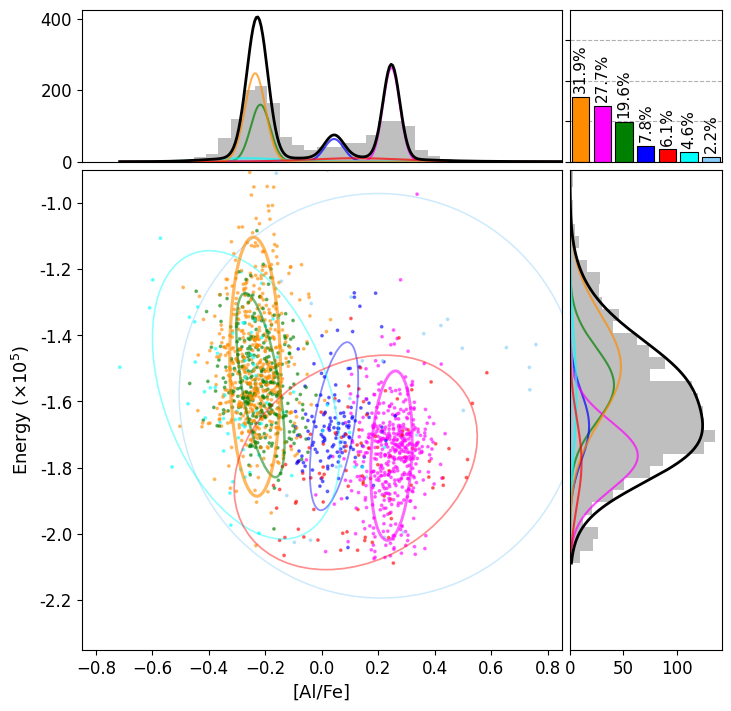

In [19]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='E_50',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-0.85, 0.85), ylim=(-2.35e5, -0.9e5),
)

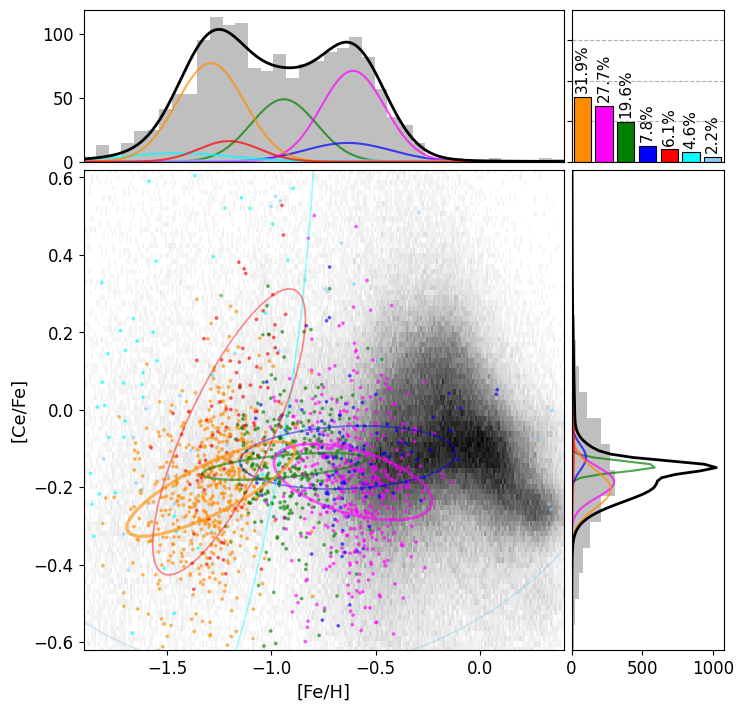

In [20]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='ce_fe',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.62, 0.62),
)

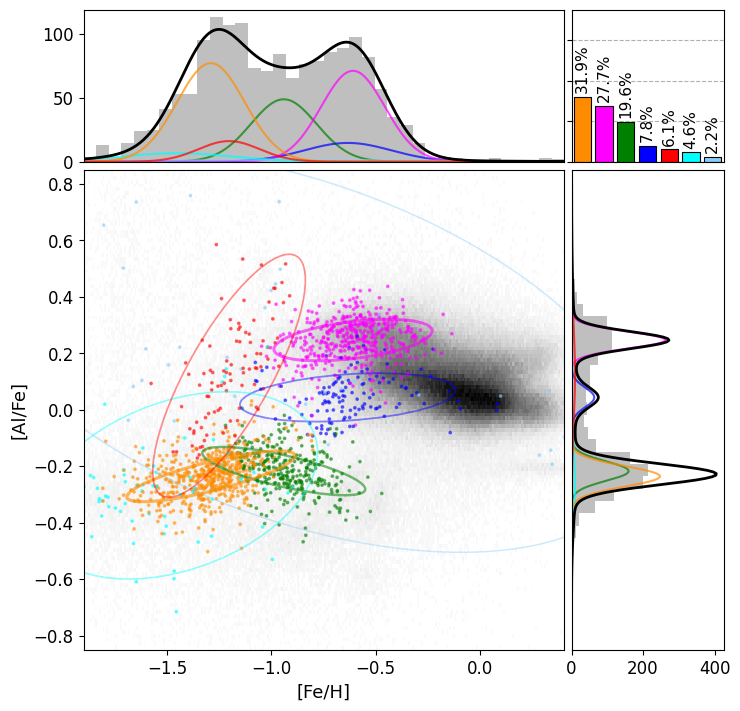

In [21]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='al_fe',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.85, 0.85),
)

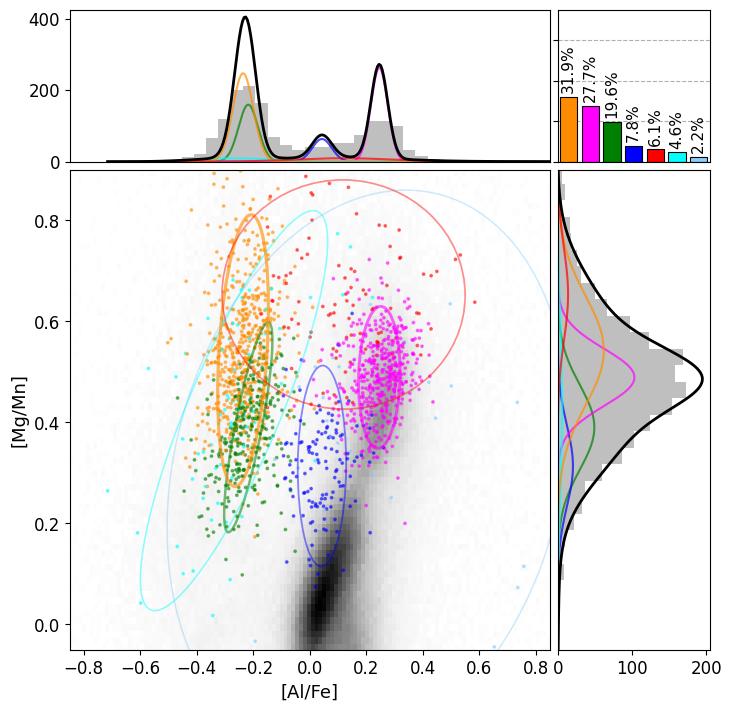

In [22]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='mg_mn',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim =(-0.85, 0.85), ylim=(-0.05, 0.9),
)

## Figure 5 Plots

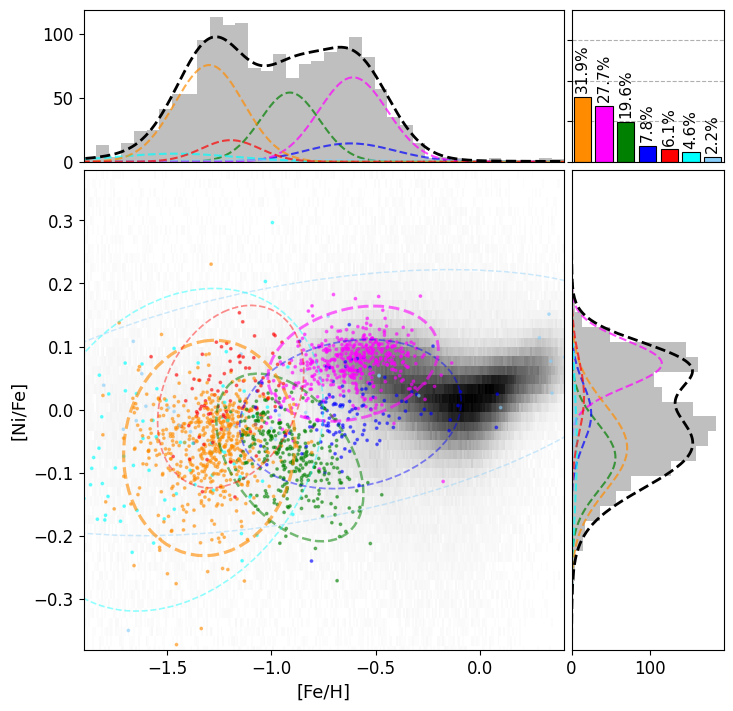

In [24]:
apogee_pipeline.plot_nonXD( x_key = 'fe_h', y_key='ni_fe',
    z_score=2,
    full_survey_file='data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits',
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim =(-1.9, 0.4), ylim=(-0.38, 0.38),
)